# <a id='toc1_'></a>[**Проект:**  Разработка модели для предсказания температуры стали](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [**Проект:**  Разработка модели для предсказания температуры стали](#toc1_)    
  - [Изучение данных](#toc1_1_)    
    - [Данные об электродах](#toc1_1_1_)    
    - [Данные о подаваемом в рабочую полость ковша инертном газе](#toc1_1_2_)    
    - [Данные о сыпучих материалах](#toc1_1_3_)    
    - [Данные по проволочным материалам](#toc1_1_4_)    
    - [Данные о температуре](#toc1_1_5_)    
    - [Вывод](#toc1_1_6_)    
  - [Подготовка данных](#toc1_2_)    
    - [Данные об электродах](#toc1_2_1_)    
    - [Данные о температуре](#toc1_2_2_)    
    - [Данные о сыпучих и проволочных материалах](#toc1_2_3_)    
    - [Итоговый датафрейм](#toc1_2_4_)    
    - [Тренировочная и тестовая выборки.](#toc1_2_5_)    
    - [Вывод](#toc1_2_6_)    
  - [Выбор модели](#toc1_3_)    
    - [Lasso](#toc1_3_1_)    
    - [Ridge](#toc1_3_2_)    
    - [RandomForest](#toc1_3_3_)    
    - [XGBoost](#toc1_3_4_)    
    - [LightGBM](#toc1_3_5_)    
    - [CatBoost](#toc1_3_6_)    
    - [Полученные результаты](#toc1_3_7_)    
  - [Тестирование модели](#toc1_4_)    
  - [Адекватность модели](#toc1_5_)    
  - [Общий вывод](#toc1_6_)    
- [Отчет](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***Описание этапа обработки***

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

***Цель работы*** - разработка модели предсказания температуры стали, с целью  для оптимизации затрат на электроэнергию.

Для реализации поставленной цели были поставлены следующие *задачи*:

- Изучить представленные данные
- Провести подготовку данных (обработка пропусков, аномальных значений, подготовка признаков)
- Выбор модели (рассмотреть несколько моделей с различными гиперпараметрами)
- Определить важность признаков для предсказания выбранной модели
- Определение итоговой метрики на тесте

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter

import optuna
from optuna.integration import OptunaSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

import phik
import warnings

In [2]:
# Отключим предупреждения 
warnings.filterwarnings('ignore')

In [3]:
# Зададим тему seaborn для графиков
sns.set_theme(style="whitegrid")

## <a id='toc1_1_'></a>[Изучение данных](#toc0_)

Представлены данные о подаче сыпучих и проволочных матриалов, продвуке сплава газом, подаваемой электрической мощности на электроды ковша для различных партий при обработки стали. 

**Описание данных:**
- *data_arc* — данные об электродах;
- *data_bulk* — данные о подаче сыпучих материалов (объём);
- *data_bulk_time* — данные о подаче сыпучих материалов (время);
- *data_gas* — данные о продувке  сплава газом;
- *data_temp* — результаты измерения температуры;
- *data_wire* — данные о проволочных материалах (объём);
- *data_wire_time*  — данные о проволочных материалах (время).

### <a id='toc1_1_1_'></a>[Данные об электродах](#toc0_)

In [4]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
except:
    data_arc = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

data_arc.rename(columns={'Начало нагрева дугой' : 'start_heating', 'Конец нагрева дугой' : 'stop_heating',
                  'Активная мощность' : 'active_power', 'Реактивная мощность' : 'reactive_power' }, inplace=True)
display(data_arc.info())
print('\n')
display(data_arc.describe())
print('\n')
display(data_arc.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   stop_heating    14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,start_heating,stop_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
data_arc['reactive_power'].value_counts().sort_index().head()

-715.504924    1
 0.020806      1
 0.021154      1
 0.022485      1
 0.022983      1
Name: reactive_power, dtype: int64

В данных о реактивной мощности присутствует одно единственное отрицательное значение.

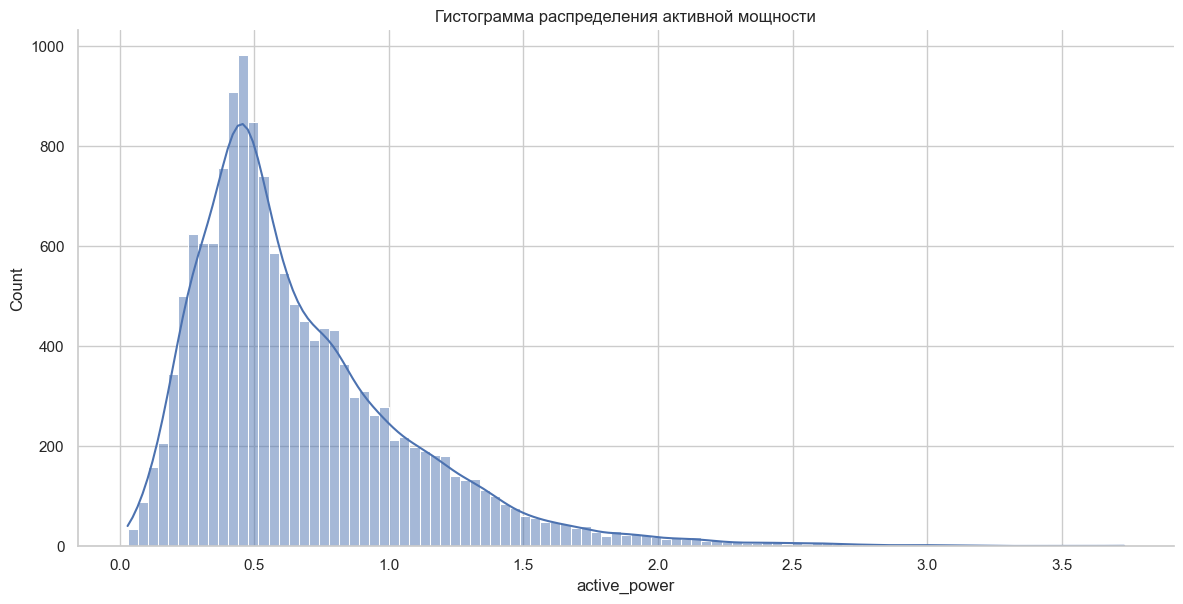

In [6]:
sns.displot(data_arc['active_power'], kde =True, height=6, aspect=2)
plt.title('Гистограмма распределения активной мощности')
plt.show()

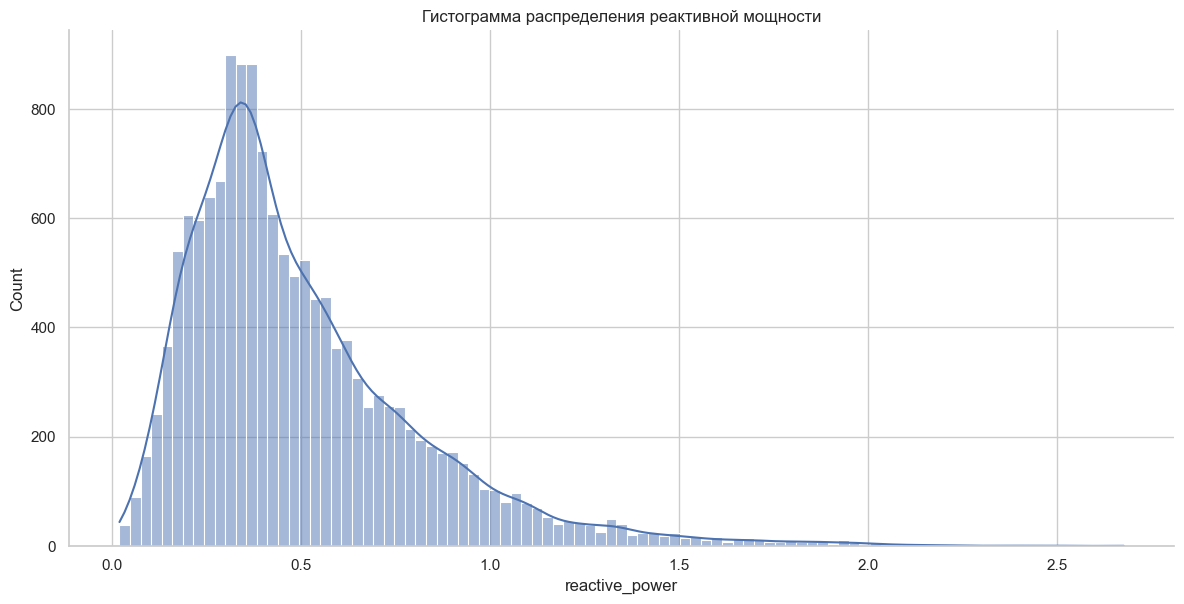

In [7]:
sns.displot(data_arc[data_arc['reactive_power'] > 0 ]['reactive_power'], kde =True, height=6, aspect=2)
plt.title('Гистограмма распределения реактивной мощности')
plt.show()

**Корреляция активной и реактивной мощностей**

In [8]:
phik.phik_matrix(data_arc[data_arc['reactive_power'] >0 ] \
                         .drop(columns=['start_heating', 'stop_heating', 'key']), 
                             interval_cols = ['key', 'active_power', 'reactive_power'])

,active_power,reactive_power
active_power,1.000000,0.954246
reactive_power,0.954246,1.000000


**Вывод:** Представленны данные подаваемой на электроды активной и реактивной мощностей, времени начала и конца нагрева для каждой из партий стали. В данных о реактивной мощности присутсвовало одно отрицательное значение.

### <a id='toc1_1_2_'></a>[Данные о подаваемом в рабочую полость ковша инертном газе](#toc0_)

In [9]:
try:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
except:
    data_gas = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_gas.csv')

data_gas.rename(columns={'Газ 1' : 'gas'}, inplace=True)
display(data_gas.info())
print('\n')
display(data_gas.describe())
print('\n')
display(data_gas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


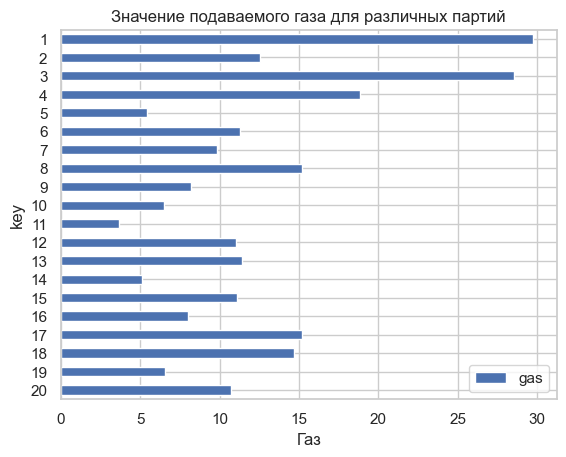

In [10]:
data_gas.query('key < 21').sort_values(by = 'key', ascending=False).plot(kind = 'barh', y = 'gas', x = 'key', title = 'Значение подаваемого газа для различных партий')
plt.xlabel('Газ')
plt.show()

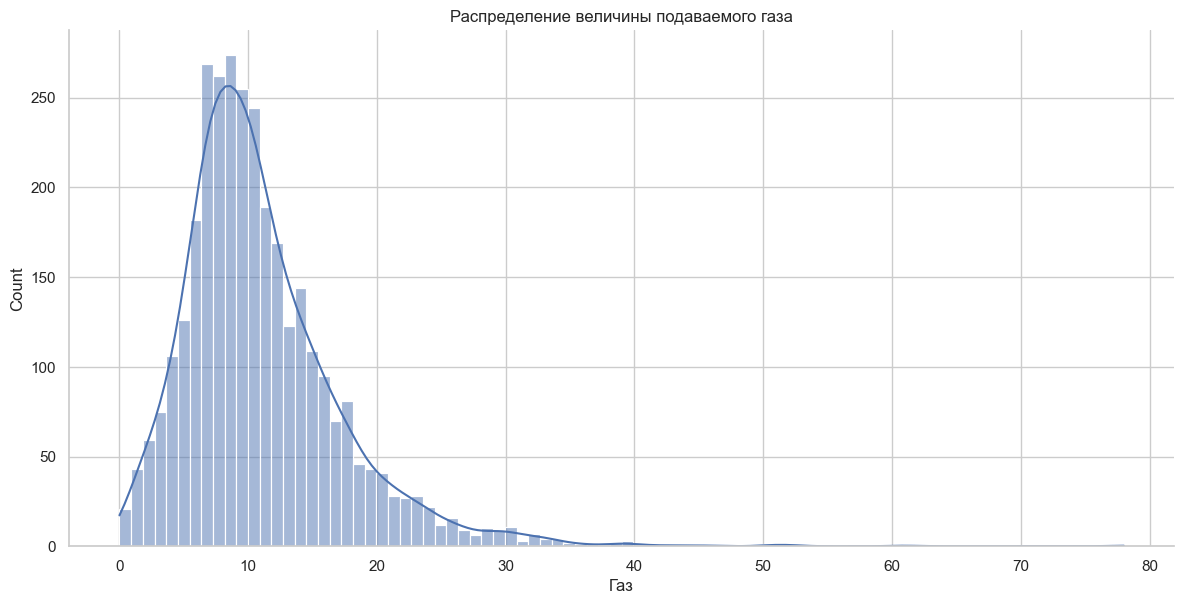

In [11]:
sns.displot(data_gas['gas'], kde=True, height=6, aspect=2)
plt.title('Распределение величины подаваемого газа')
plt.xlabel('Газ')
plt.show()

**Вывод:** Распределение в данных о подаваемом газе похоже на логнормальное, пропуски в данных отсутсвуют.

### <a id='toc1_1_3_'></a>[Данные о сыпучих материалах](#toc0_)

In [12]:
try:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
except:
    data_bulk = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_bulk.csv')
display(data_bulk.info())
print('\n')
display(data_bulk.describe())
print('\n')
display(data_bulk.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


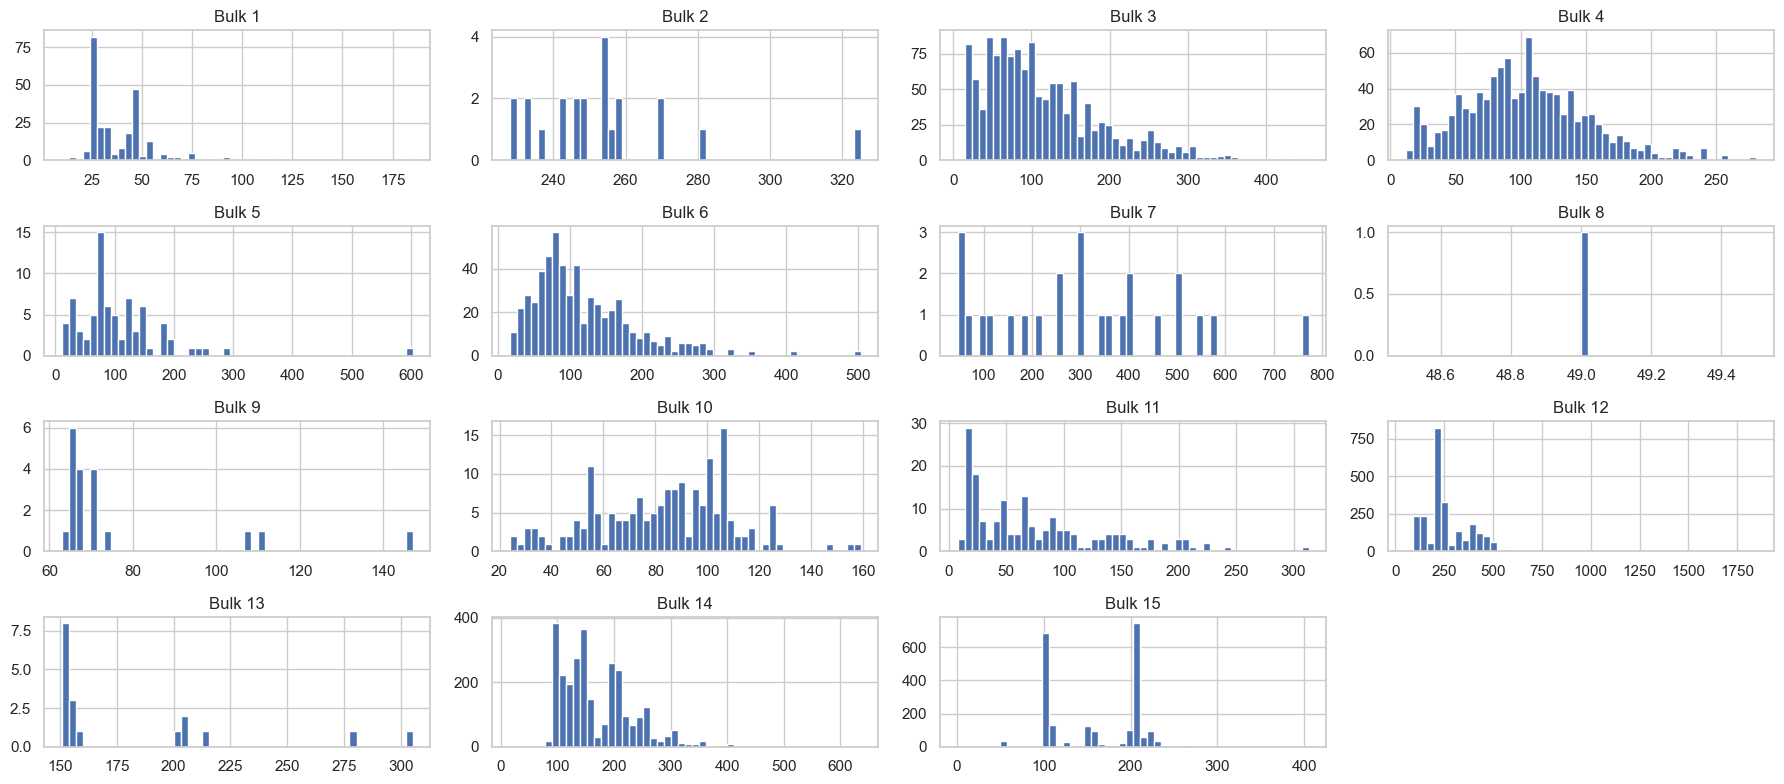

In [13]:
data_bulk.drop('key', axis=1).hist(figsize=(18,8), bins = 50)
plt.tight_layout()

In [14]:
try:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates=list(range(1,16)))
except:
    data_bulk_time = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_bulk_time.csv', parse_dates=list(range(1,16)))

display(data_bulk_time.info())
print('\n')
display(data_bulk_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


**Вывод:** Представлены данные о сыпучих материалах и времени подачи их в ковш. В данных присутсвуют пропуски, предположительно из-за того, что данный материал в конкретную партию не подавался.

### <a id='toc1_1_4_'></a>[Данные по проволочным материалам](#toc0_)

In [15]:
try:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
except:
    data_wire = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_wire.csv')

display(data_wire.info())
print('\n')
display(data_wire.describe())
print('\n')
display(data_wire.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


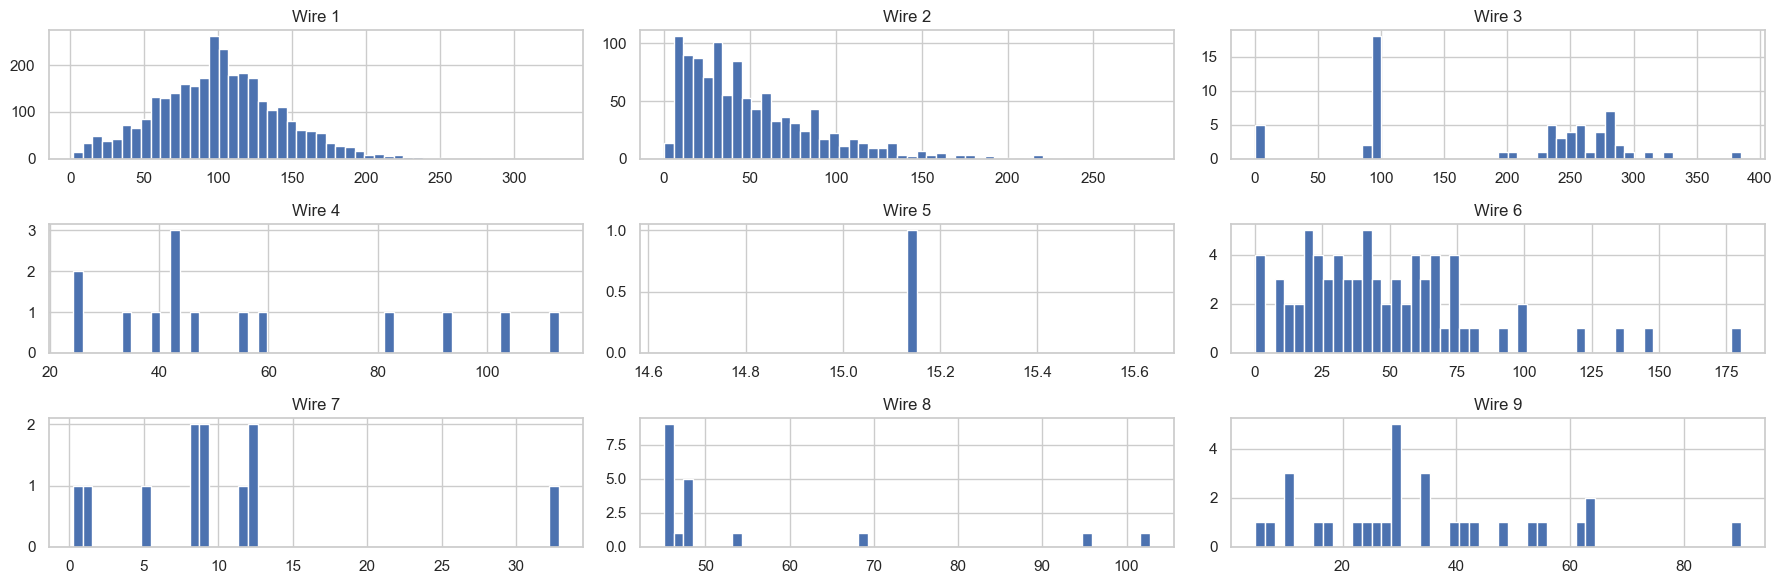

In [16]:
data_wire.drop('key',axis=1).hist(figsize=(18,6), bins=50)
#plt.title("Гистограммы распределения по каждому из проволочных материалов")
plt.tight_layout()

In [17]:
try:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=list(range(1,10)))
except:
    data_wire_time = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_wire_time.csv', parse_dates=list(range(1,10)))

display(data_wire_time.info())
display(data_wire_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Вывод:** Представлены данные о проволочных материалах и времени подачи их в ковш. В данных присутсвуют пропуски, предположительно из-за того, что данный материал в конкретную партию не подавался.

### <a id='toc1_1_5_'></a>[Данные о температуре](#toc0_)

In [18]:
try:
    data_temp = pd.read_csv('', parse_dates=['Время замера'])
except:
    data_temp = pd.read_csv('D:\YP_projects\Final_Project\Final_steel\data_temp.csv', parse_dates=['Время замера'])

data_temp.rename(columns={'Время замера' : 'measurement_time','Температура' : 'temperature'}, inplace=True)
display(data_temp.info())
print('\n')
display(data_temp.describe(percentiles=[.01, 0.05, .25, .75]))
print('\n')
display(data_temp.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               15907 non-null  int64         
 1   measurement_time  15907 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
1%,29.000000,1544.000000
5%,139.000000,1562.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Подсчитаем количество пропусков в данных.

In [19]:
data_temp.isna().sum()

key                    0
measurement_time       0
temperature         2901
dtype: int64

Кол-во значений, попадающих в 1% квантиль.

In [20]:
quantile_001 = data_temp.drop(["key","measurement_time"], axis=1).quantile(0.01).values[0]
print(f'Однопроцентный квантиль: {quantile_001}')
print('Кол-во значений меньше однопроцентного квантиля:')
data_temp.query('temperature < @quantile_001')['temperature'].count()

Однопроцентный квантиль: 1544.0
Кол-во значений меньше однопроцентного квантиля:


130

Кол-во значений, попадающих в 5% квантиль.

In [21]:
quantile_005 = data_temp.drop(["key","measurement_time"], axis=1).quantile(0.05).values[0]
print(f'Пятипроцентный квантиль: {quantile_005}')
print('Кол-во значений меньше пятипроцентного квантиля:')
data_temp.query('temperature < @quantile_005')['temperature'].count()

Пятипроцентный квантиль: 1562.0
Кол-во значений меньше пятипроцентного квантиля:


622

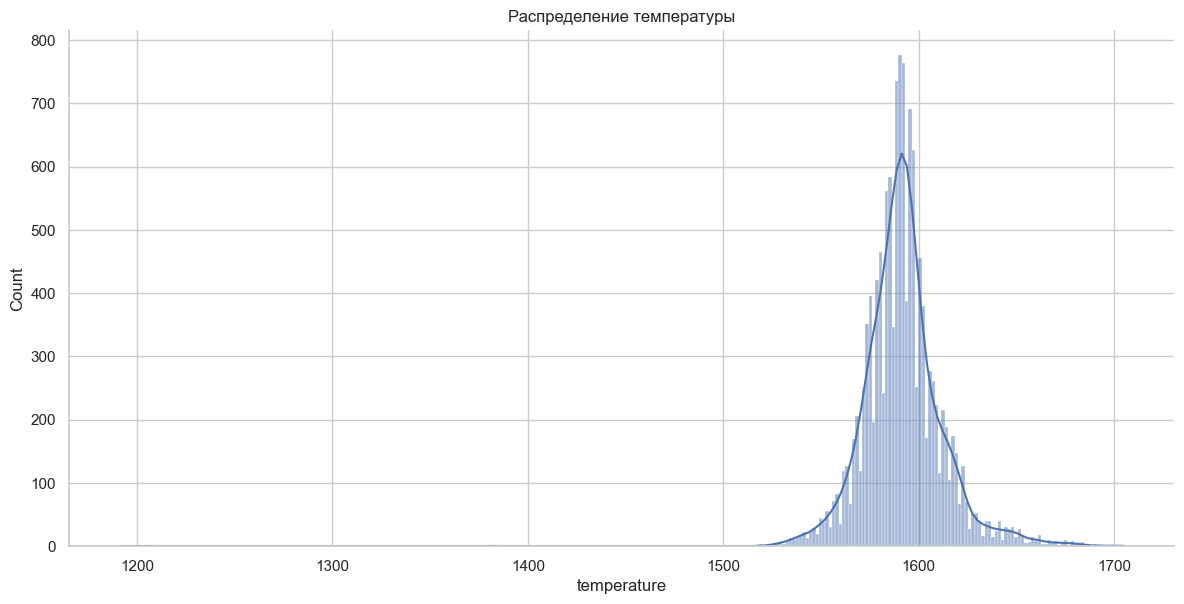

In [22]:
sns.displot(data_temp['temperature'], kde=True, height=6, aspect=2)
plt.title('Распределение температуры')
plt.show()

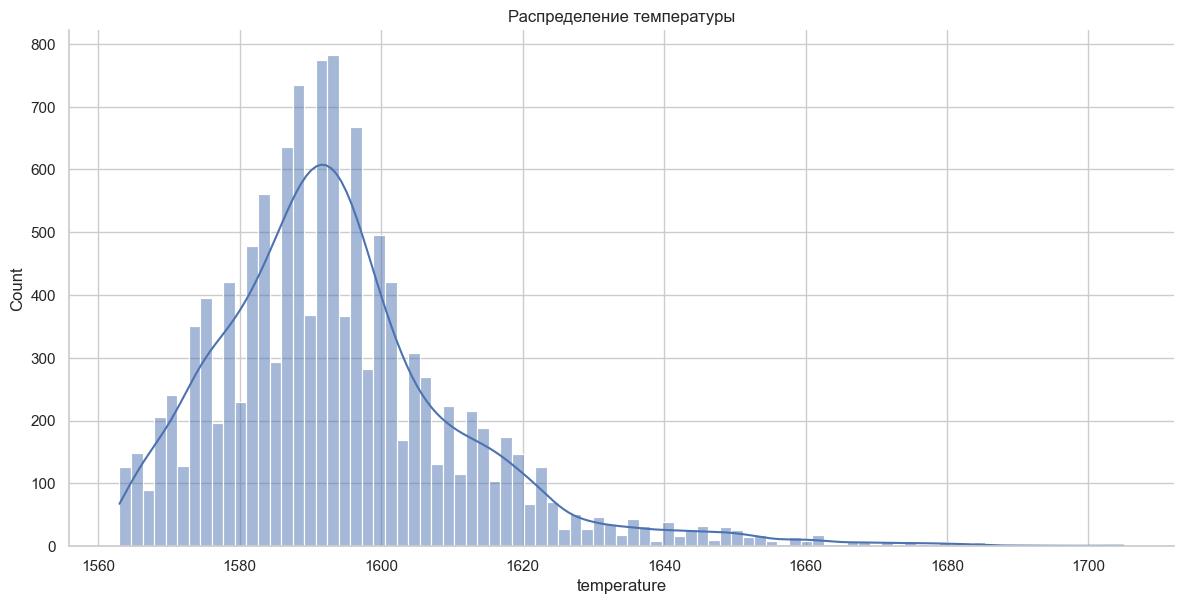

In [23]:
sns.displot(data_temp.query('temperature  > 1562')['temperature'], kde=True, height=6, aspect=2)
plt.title('Распределение температуры')
plt.show()

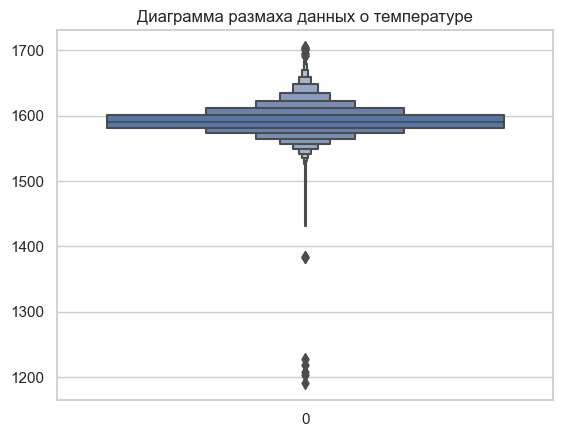

In [24]:
sns.boxenplot(data_temp['temperature'])
plt.title('Диаграмма размаха данных о температуре')
plt.show()

Графики изменения температуры для различных партий.

In [25]:
# Палитра цветов из seaborn
col_pal = sns.color_palette()

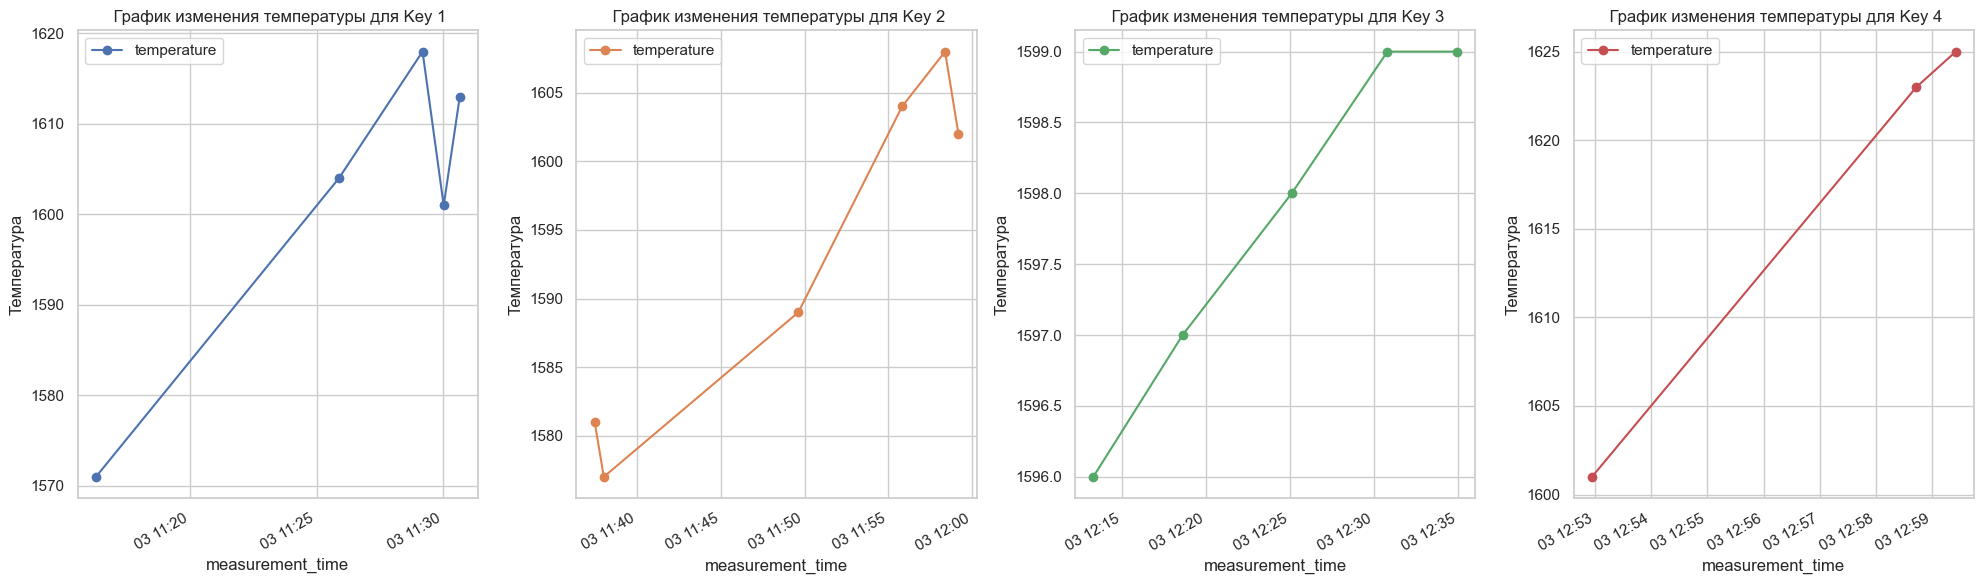

In [26]:
fig, ax  = plt.subplots(1,4, figsize=(20,6))
for i in range(1,5):
    data_temp.query('key == @i').plot( x ='measurement_time', y = 'temperature',
                                      ax = ax[i-1], c = col_pal[i-1], grid=True, 
                                      title = f' График изменения температуры для Key {i}',
                                     ylabel ='Температура', style = ['-o']
                                     ) 
plt.tight_layout()

**Вывод:** В данных представлены замеры температуры в различные временные отрезки обработки стали. В данных присутствуют выбросы и пропуски. Расределение температур похоже на нормальное.

### <a id='toc1_1_6_'></a>[Вывод](#toc0_)

* Представлены данные о подаче сыпучих и проволочных матриалов, продвуке сплава газом, подаваемой электрической мощности на электроды ковша для различных партий при обработки стали. 
* Представленны данные подаваемой на электроды активной и реактивной мощностей, времени начала и конца нагрева для каждой из партий стали. В данных о реактивной мощности присутсвовало одно отрицательное значение.
* Распределение в данных о подаваемом газе похоже на логнормальное, пропуски в данных отсутсвуют.
* Представлены данные о сыпучих и проволочных материалах, а также времени подачи их в ковш. В данных присутсвуют пропуски, предположительно из-за того, что данный материал в конкретную партию не подавался.
* В данных о температуре предсталены замеры в различные временные отрезки обработки стали. В данных присутствуют выбросы и пропуски. Расределение температур похоже на нормальное.

## <a id='toc1_2_'></a>[Подготовка данных](#toc0_)

* Аномальные значения в температуре и данных о мощности на электродах
* Удалить key партий, где есть пропущенные значения температуры или присутсвует только один замер
* Добавить новые признаки, удалить коррелирующие признаки
* Заполнить пропуски в data_wire и data_bulk
* Объединить данные по общему key
* Подготовка features и target 
* Подготовка тренировочной и тестовой выборок

**Целевым признаком** является конечная температура расплава.

### <a id='toc1_2_1_'></a>[Данные об электродах](#toc0_)

Рассмотрим данные об электродах.

*Активная мощность* - характеризует скорость необратимого превращения электрической энергии в другие виды энергии (тепловую и электромагнитную-только ту которая не вернется в источник). 

*Реактивная мощность* - это энергия, перекачиваемая от источника на реактивные элементы приёмника (индуктивности, конденсаторы, обмотки двигателей), а затем возвращаемая этими элементами обратно в источник в течение одного периода колебаний, отнесённая к этому периоду.

*Полная мощность* - является векторной суммой *активной* и *реактивной* мощностей.

In [27]:
df_arc = data_arc.copy()

Пропуски в данных об электродах отсутсвуют.

In [28]:
df_arc.isna().sum()

key               0
start_heating     0
stop_heating      0
active_power      0
reactive_power    0
dtype: int64

В данных присутвует одно отрицательное значение реактивной мощности. С точки зрения физики, реактивная мощность может принимать отрицательные значения, что подразумевает изменению характера нагрузки характера с активно-индуктивной на активно-ёмкостный, однако значение довольно сильно выбивается по модулю от максимального значения реактивной мощности, поэтому принято решение считать это выбросом.

In [29]:
df_arc[df_arc['reactive_power'] < 0]

,key,start_heating,stop_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [30]:
df_arc['reactive_power'].max()

2.6763875484

In [31]:
df_arc = df_arc[df_arc['reactive_power']> 0]

Определим промежутки времени нагрева соотвествующей мощностью и переведем эти значения в секунды.

In [32]:
delta = df_arc.loc[:,'stop_heating'] - df_arc.loc[:,'start_heating']
delta

0       0 days 00:03:48
1       0 days 00:03:05
2       0 days 00:02:52
3       0 days 00:06:05
4       0 days 00:02:28
              ...      
14871   0 days 00:02:37
14872   0 days 00:03:00
14873   0 days 00:03:04
14874   0 days 00:00:57
14875   0 days 00:01:21
Length: 14875, dtype: timedelta64[ns]

In [33]:
delta_sec = delta.dt.total_seconds().astype('int')
delta_sec

0        228
1        185
2        172
3        365
4        148
        ... 
14871    157
14872    180
14873    184
14874     57
14875     81
Length: 14875, dtype: int32

Определим полную мощность, как вектурную сумму активной и реактивной, а так же затрачиваемую энергию на процесс нагрева, как произведение мощности нагрева на время нагрева.

In [34]:
df_arc['total_power'] = np.sqrt(df_arc['active_power'] ** 2 + df_arc['reactive_power'] ** 2)
df_arc['energy'] = df_arc['total_power'] * delta_sec
df_arc

,key,start_heating,stop_heating,active_power,reactive_power,total_power,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,119.471318
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,100.581755
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,154.000682
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,160.919002
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,15.075853


Корреляция признаков

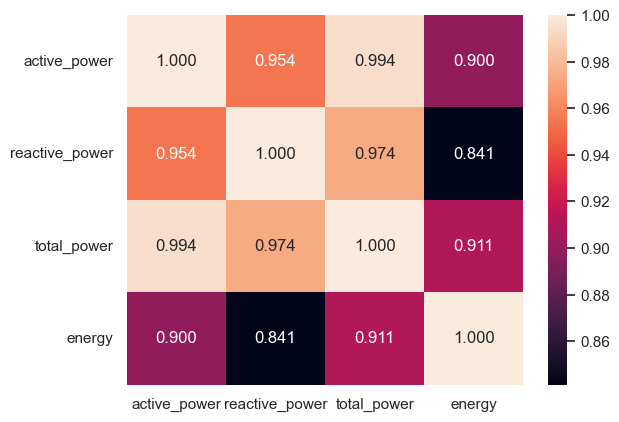

In [35]:
phik_corr = phik.phik_matrix(df_arc \
                         .drop(columns=['start_heating', 'stop_heating', 'key']), 
                             interval_cols = ['key', 'active_power', 'reactive_power', 'total_power', 'energy'])
sns.heatmap(phik_corr,annot=True, fmt='.3f')
plt.show()

Признаки довольно сильно коррелируют между собой. В качестве признака используем суммарную энергию, затраченную на подогрев расплава. 

Просуммируем затраченную энергию на подогрев по каждой партии.

In [36]:
total_energy = df_arc.pivot_table(values='energy', index='key', aggfunc='sum')
total_energy.rename(columns={'energy':'total_energy'}, inplace=True)
total_energy

,total_energy
key,
1,1442.377754
2,881.233565
3,525.066777
4,796.911309
5,1199.137958
...,...
3237,958.336236
3238,555.867370
3239,1013.067719


### <a id='toc1_2_2_'></a>[Данные о температуре](#toc0_)

В качестве *целевого признака* для нашей модели будет использоваться конечная температура расплава. Начальная температура (при первом измерении) будет использоваться как *признак* для модели.

Данные о замерах, где присутсвуют пропуски или только один замер нам не подойдут, поэтому удалим их.

In [37]:
df_temp = data_temp.copy()

Удалим key, где есть пропуски в замерах температуры

In [38]:
df_temp.isna().sum()

key                    0
measurement_time       0
temperature         2901
dtype: int64

In [39]:
keys_to_drop = df_temp[df_temp['temperature'].isnull()]['key'].unique()
print(keys_to_drop)

[2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513
 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527
 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541
 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555
 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569
 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581 2582 2583
 2584 2585 2586 2587 2588 2589 2590 2591 2592 2593 2594 2595 2596 2597
 2598 2599 2600 2601 2602 2603 2604 2605 2606 2607 2608 2609 2610 2611
 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621 2622 2623 2624 2625
 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638 2639
 2640 2641 2642 2643 2644 2645 2646 2647 2648 2649 2650 2651 2652 2653
 2654 2655 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666 2667
 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677 2678 2679 2680 2681
 2682 2684 2685 2686 2687 2688 2689 2690 2691 2692 2693 2694 2695 2696
 2697 

In [40]:
df_temp[df_temp['key'] == 2927]

,key,measurement_time,temperature
14429,2927,2019-08-21 15:27:21,1563.0
14430,2927,2019-08-21 15:35:59,NaN
14431,2927,2019-08-21 15:36:35,NaN
14432,2927,2019-08-21 15:47:20,NaN
14433,2927,2019-08-21 15:53:50,NaN


Удалим партии, в замерах у которых имеются пропуски.

In [41]:
df_temp = df_temp[~df_temp['key'].isin(keys_to_drop)]

Температура плавления стали 1300-1500 градусов Цельсия. Большая часть данных превышает порог 1500 градусов, поэтому отфильтруем значения ниже этого порога.

In [42]:
df_temp.drop('key', axis=1).quantile(0.01)

temperature    1545.0
Name: 0.01, dtype: float64

In [43]:
df_temp.query('temperature < 1500')

,key,measurement_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0


In [44]:
anomaly_keys = df_temp.query('temperature < 1500')['key'].unique()
anomaly_keys

array([ 867, 1214, 1619, 1818, 2052], dtype=int64)

In [45]:
df_temp = df_temp[~df_temp['key'].isin(anomaly_keys)]

Отберем последние и первые значения замеров температуры для каждого ключа. 

Добавим разницу между первым и последним замерами как признак measurement_delta.

In [46]:
first_last_values = df_temp.groupby('key').agg(first_measure = ('measurement_time', 'first'),
                          last_measure = ('measurement_time', 'last'),
                          first_temperature = ('temperature', 'first'),
                          last_temperature = ('temperature', 'last'))
first_last_values = first_last_values.astype({'last_temperature':'int','first_temperature':'int'})

first_last_values['measurement_delta'] = (first_last_values['last_measure']
                                          - first_last_values['first_measure']).dt.total_seconds().astype('int')
first_last_values

,first_measure,last_measure,first_temperature,last_temperature,measurement_delta
key,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571,1613,861
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581,1602,1305
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596,1599,1300
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601,1625,388
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576,1602,762
...,...,...,...,...,...
2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570,1591,1137
2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554,1591,1618
2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571,1589,717


Значения, в которых конечная температура равна начальной.

In [47]:
first_last_values[first_last_values['first_temperature'] == first_last_values['last_temperature']]

,first_measure,last_measure,first_temperature,last_temperature,measurement_delta
key,,,,,
63,2019-05-05 15:53:11,2019-05-05 16:15:32,1580,1580,1341
195,2019-05-10 14:10:23,2019-05-10 14:10:23,1583,1583,0
197,2019-05-10 16:31:15,2019-05-10 16:40:40,1582,1582,565
262,2019-05-13 04:42:00,2019-05-13 05:32:24,1596,1596,3024
279,2019-05-13 23:07:28,2019-05-13 23:07:28,1603,1603,0
489,2019-05-21 15:21:59,2019-05-21 15:33:18,1593,1593,679
573,2019-05-24 13:51:32,2019-05-24 14:23:29,1575,1575,1917
586,2019-05-25 01:15:23,2019-05-25 01:28:18,1594,1594,775
623,2019-05-26 06:23:22,2019-05-26 06:33:27,1597,1597,605


In [48]:
first_last_values[first_last_values['first_temperature'] == first_last_values['last_temperature']].count()

first_measure        44
last_measure         44
first_temperature    44
last_temperature     44
measurement_delta    44
dtype: int64

Данные значения было принято решение оставить, так как они не противоречат физике процесса обработки стали.

### <a id='toc1_2_3_'></a>[Данные о сыпучих и проволочных материалах](#toc0_)

In [49]:
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [50]:
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

В данных о проволочных и сыпучих материалах присутсвтуют пропуски, предположительно из-за того, что данный материал в партию не добавлялся. Пропуски данных заполним значеним 0.
Данные data_wire_time и data_bulk_time исключим из рассмотрения. Пропуски заполним с помощью SimpleImputer в pipeline.

### <a id='toc1_2_4_'></a>[Итоговый датафрейм](#toc0_)

Объединим данные в общую таблицу. В итогувую таблицу поместим данные только о тех партиях, которые присутсвуют во всех датасетах. Колонки first_measure и last_measure исключим, так как добавлен обобщающий признак времени измерения measurement_delta. 

In [51]:
df = first_last_values.drop(columns=['first_measure', 'last_measure']).merge(total_energy, how='inner', on='key')
df = df.merge(data_gas, how='inner', on='key', copy=True)
df = df.merge(data_bulk, how='inner', on='key', copy=True)
df = df.merge(data_wire, how='inner', on='key', copy=True)
df = df.set_index('key')
df 

,first_temperature,last_temperature,measurement_delta,total_energy,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,861,1442.377754,29.749986,NaN,NaN,NaN,43.0,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1581,1602,1305,881.233565,12.555561,NaN,NaN,NaN,73.0,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1596,1599,1300,525.066777,28.554793,NaN,NaN,NaN,34.0,NaN,...,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1601,1625,388,796.911309,18.841219,NaN,NaN,NaN,81.0,NaN,...,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1576,1602,762,1199.137958,5.413692,NaN,NaN,NaN,78.0,NaN,...,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,1137,778.818234,7.125735,NaN,NaN,21.0,NaN,NaN,...,223.0,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2496,1554,1591,1618,875.261419,9.412616,NaN,NaN,NaN,63.0,NaN,...,226.0,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2497,1571,1589,717,556.930349,6.271699,NaN,NaN,NaN,85.0,NaN,...,226.0,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <a id='toc1_2_5_'></a>[Тренировочная и тестовая выборки.](#toc0_)

Разобьем данные на тренировочную и тестовую подвыборки.

In [52]:
#Зададимся random_state
RND_ST = 100423

In [53]:
train, test = train_test_split(df, test_size = 0.25, random_state = RND_ST)

In [54]:
features_train = train.drop('last_temperature', axis=1)
target_train = train['last_temperature']

features_test = test.drop('last_temperature', axis=1)
target_test = test['last_temperature']

### <a id='toc1_2_6_'></a>[Вывод](#toc0_)

* Удалены аномальные значения в данных о температуре и электродах
* Удалены пропуски в данных о температуре
* Решено заполнять пропуски в data_wire и data_bulk значением 0, как отсутсвие конкретной добавки в сталь при обработке
* Добавлены новые признаки о суммарно затраченной энергии на переработку total_energy и временной разнице при замерах начальной и конечной температур measurement_delta
* Удалены некоторые коррелирующие признаки
* Данные агрегированны по общему key - номер партии 
* Данные разделены на features и target
* Подготовлены обучающая и тестовая выборки

## <a id='toc1_3_'></a>[Выбор модели](#toc0_)

В качестве моделей рассмотрим линейную модель Lasso, Ridge, модели XGBoost, LightGBM, CatBoost и модель RandomForest.

In [55]:
# Словарь для результатов работы рассматриваемых моделей
results = {}

Функция для сбора результатов метрики на модели, определения время fit и predict, а так же построения графика Feature Inmportances.

In [56]:
def ModelResults(model_search, model_name, results):
    
    model = model_search.best_estimator_
    
    #Определим время fit модели 
    t_start_1 = perf_counter()
    model.fit(features_train, target_train)
    t_stop_1 = perf_counter()

    #Определим время predict модели 
    t_start_2 = perf_counter()
    model.predict(features_train)
    t_stop_2 = perf_counter()

    results[model_name] = [abs(model_search.best_score_), t_stop_1 - t_start_1, t_stop_2 - t_start_2]
    try:
        pd.DataFrame(model.feature_importances_, 
                       index = features_train.columns, 
                       columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')
    except:
        pd.DataFrame(model[-1].feature_importances_, 
                       index = features_train.columns, 
                       columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')        
    plt.show()

### <a id='toc1_3_1_'></a>[Lasso](#toc0_)

In [57]:
%%time
lasso_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                        ('scaler', StandardScaler()),
                        ('model', Lasso(random_state = RND_ST))])

#linear_pipe.fit(features_train, target_train)
cross_val_lasso = cross_val_score(lasso_pipe, features_train, target_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(cross_val_lasso)
print(abs(cross_val_lasso.mean()))

[-6.11716142 -6.62726146 -6.59065558 -7.07273097 -6.37631545]
6.556824974479531
CPU times: total: 0 ns
Wall time: 849 ms


<Axes: title={'center': 'Feature Importances'}>

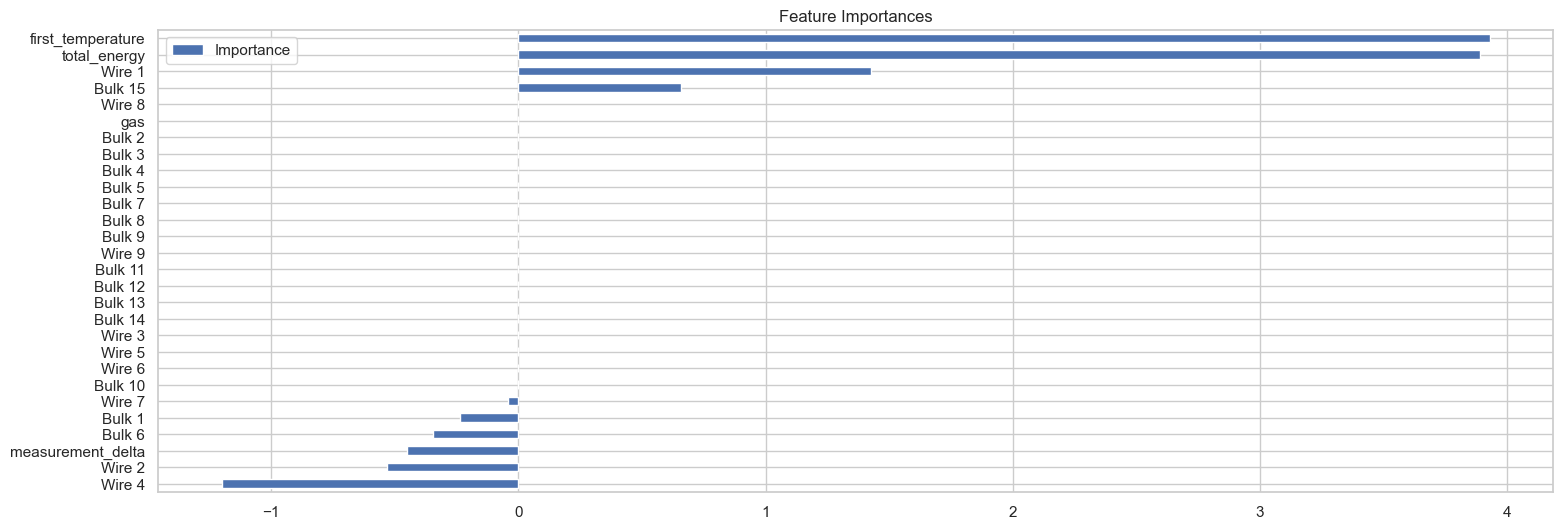

In [58]:
#Определим время fit модели 
t_start_1 = perf_counter()
lasso_pipe.fit(features_train, target_train)
t_stop_1 = perf_counter()

#Определим время predict модели 
t_start_2 = perf_counter()
lasso_pipe.predict(features_train)
t_stop_2 = perf_counter()

results['Lasso'] = [abs(cross_val_lasso.mean()), t_stop_1 - t_start_1, t_stop_2 - t_start_2]

pd.DataFrame(lasso_pipe['model'].coef_, 
                       index = features_train.columns, 
                       columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')

### <a id='toc1_3_2_'></a>[Ridge](#toc0_)

In [59]:
%%time
linear_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                        ('scaler', StandardScaler()),
                        ('model', Ridge(random_state = RND_ST))])

#linear_pipe.fit(features_train, target_train)
cross_val_ridge = cross_val_score(linear_pipe, features_train, target_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(cross_val_ridge)
print(abs(cross_val_ridge.mean()))

[-5.6970431  -6.29577587 -6.30065492 -6.46568792 -5.94892464]
6.141617289407483
CPU times: total: 31.2 ms
Wall time: 131 ms


array([ 6.9305174 , -3.37517225,  7.52938266,  0.15824615, -1.24652796,
        0.51432185, -0.01830282,  0.20240282, -0.09062808, -0.67761557,
       -0.01458957,  0.        ,  0.64167757, -0.10428896, -0.35185663,
       -0.18297045, -0.09481276, -0.12884672,  1.04002729,  1.84219963,
       -1.002898  ,  0.06554849, -1.38944606,  0.        , -0.05667693,
       -0.64048737, -0.47862639,  0.05693114])

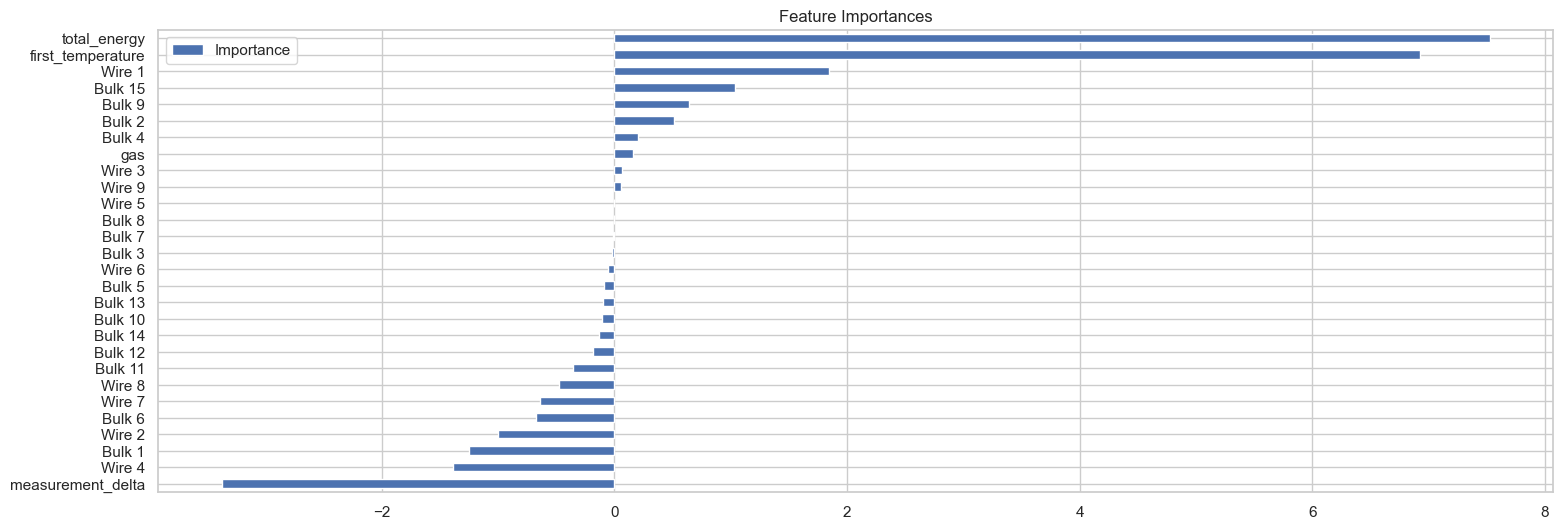

In [60]:

#Определим время fit модели 
t_start_1 = perf_counter()
linear_pipe.fit(features_train, target_train)
t_stop_1 = perf_counter()

#Определим время predict модели 
t_start_2 = perf_counter()
linear_pipe.predict(features_train)
t_stop_2 = perf_counter()

results['Ridge'] = [abs(cross_val_ridge.mean()), t_stop_1 - t_start_1, t_stop_2 - t_start_2]

display(linear_pipe['model'].coef_)
pd.DataFrame(linear_pipe['model'].coef_, 
                       index = features_train.columns, 
                       columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')
plt.show()

### <a id='toc1_3_3_'></a>[RandomForest](#toc0_)

In [61]:
preprocessing = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0))])

[I 2023-04-18 11:39:26,865] A new study created in memory with name: no-name-20e525e1-ac26-4c55-9002-53bbf4c1c302
[I 2023-04-18 11:39:36,068] Trial 10 finished with value: -6.391724449474753 and parameters: {'model__max_depth': 5, 'model__min_samples_split': 3}. Best is trial 10 with value: -6.391724449474753.
[I 2023-04-18 11:39:36,202] Trial 14 finished with value: -6.387576850390461 and parameters: {'model__max_depth': 5, 'model__min_samples_split': 2}. Best is trial 14 with value: -6.387576850390461.
[I 2023-04-18 11:39:37,479] Trial 4 finished with value: -6.262009302210873 and parameters: {'model__max_depth': 6, 'model__min_samples_split': 2}. Best is trial 4 with value: -6.262009302210873.
[I 2023-04-18 11:39:38,643] Trial 6 finished with value: -6.15226782352163 and parameters: {'model__max_depth': 7, 'model__min_samples_split': 3}. Best is trial 6 with value: -6.15226782352163.
[I 2023-04-18 11:39:39,361] Trial 11 finished with value: -6.09790821021863 and parameters: {'model_



Лучшие параметры: {'model__max_depth': 12, 'model__min_samples_split': 4}
MAE на тренировочной выборке: 6.036806135446655


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('model',
                 RandomForestRegressor(max_depth=12, min_samples_split=4,
                                       random_state=100423))])

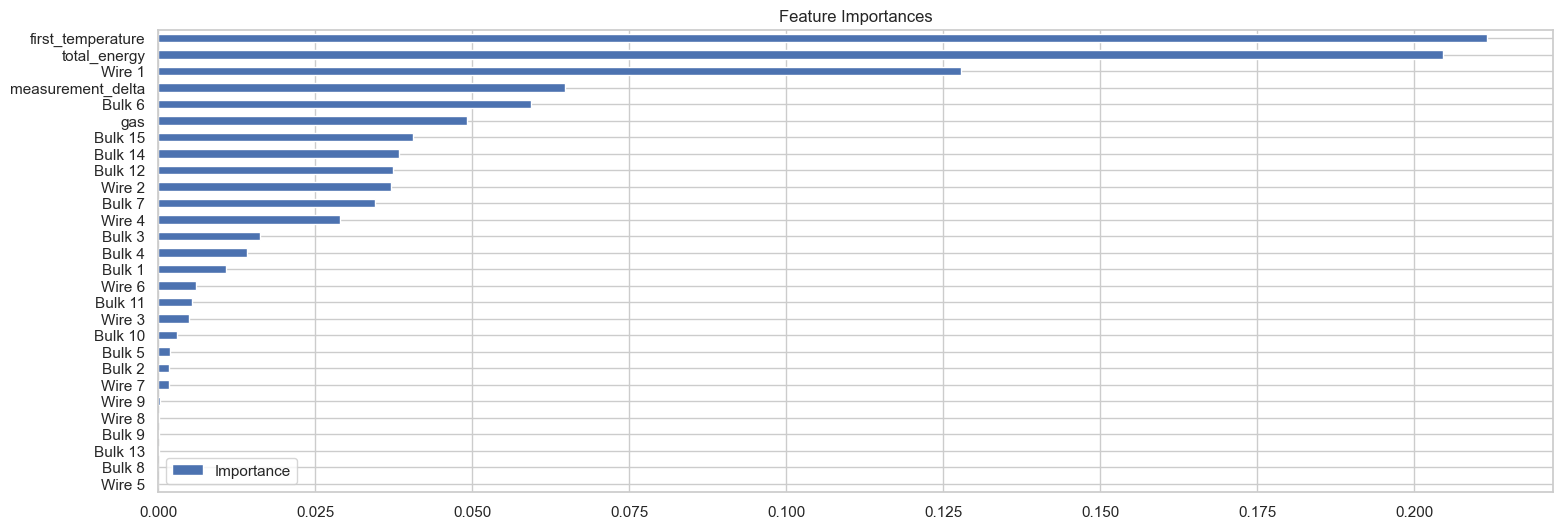

CPU times: total: 5min
Wall time: 49.4 s


In [62]:
%%time

RF_pipe = Pipeline([('preprocess', preprocessing),  ('model', RandomForestRegressor(random_state=RND_ST))]) 

parameters_RF = {
              'model__max_depth': optuna.distributions.IntDistribution(3,20),
              'model__min_samples_split': optuna.distributions.IntDistribution(2, 5)} # Добавить параметры


optuna_search_RF = OptunaSearchCV(RF_pipe, parameters_RF, n_trials=50, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RND_ST) 
optuna_search_RF.fit(features_train, target_train)


print('\n')
print(f'Лучшие параметры: {optuna_search_RF.best_params_}')
print(f'MAE на тренировочной выборке: {abs(optuna_search_RF.best_score_)}')
display(optuna_search_RF.best_estimator_)
ModelResults(optuna_search_RF, 'Random Forest', results)

- Наиболee важные признаки: начальная температура first_temperature, суммарной энергии нагрева total_energy, проволочный материал Wire 1.

### <a id='toc1_3_4_'></a>[XGBoost](#toc0_)

[I 2023-04-18 11:40:16,241] A new study created in memory with name: no-name-abf71927-6565-4165-a899-f9b53b677ecb
[I 2023-04-18 11:40:17,607] Trial 13 finished with value: -545.6759501905202 and parameters: {'model__max_depth': 10, 'model__eta': 0.01066128256527947, 'model__n_estimators': 100}. Best is trial 13 with value: -545.6759501905202.
[I 2023-04-18 11:40:18,033] Trial 5 finished with value: -313.49448046395776 and parameters: {'model__max_depth': 15, 'model__eta': 0.010784729661192196, 'model__n_estimators': 150}. Best is trial 5 with value: -313.49448046395776.
[I 2023-04-18 11:40:18,877] Trial 2 finished with value: -750.5238627881765 and parameters: {'model__max_depth': 3, 'model__eta': 0.0030069653383977568, 'model__n_estimators': 250}. Best is trial 5 with value: -313.49448046395776.
[I 2023-04-18 11:40:19,117] Trial 16 finished with value: -1143.2662944288015 and parameters: {'model__max_depth': 14, 'model__eta': 0.0022088764130252926, 'model__n_estimators': 150}. Best is



Лучшие параметры: {'model__max_depth': 5, 'model__eta': 0.012636270602219382, 'model__n_estimators': 900}
RMSE на тренировочной выборке: 5.831609202437936


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False,
                              eta=0.012636270602219382, eval_metric=None,
                              feature_types=...gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=900,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

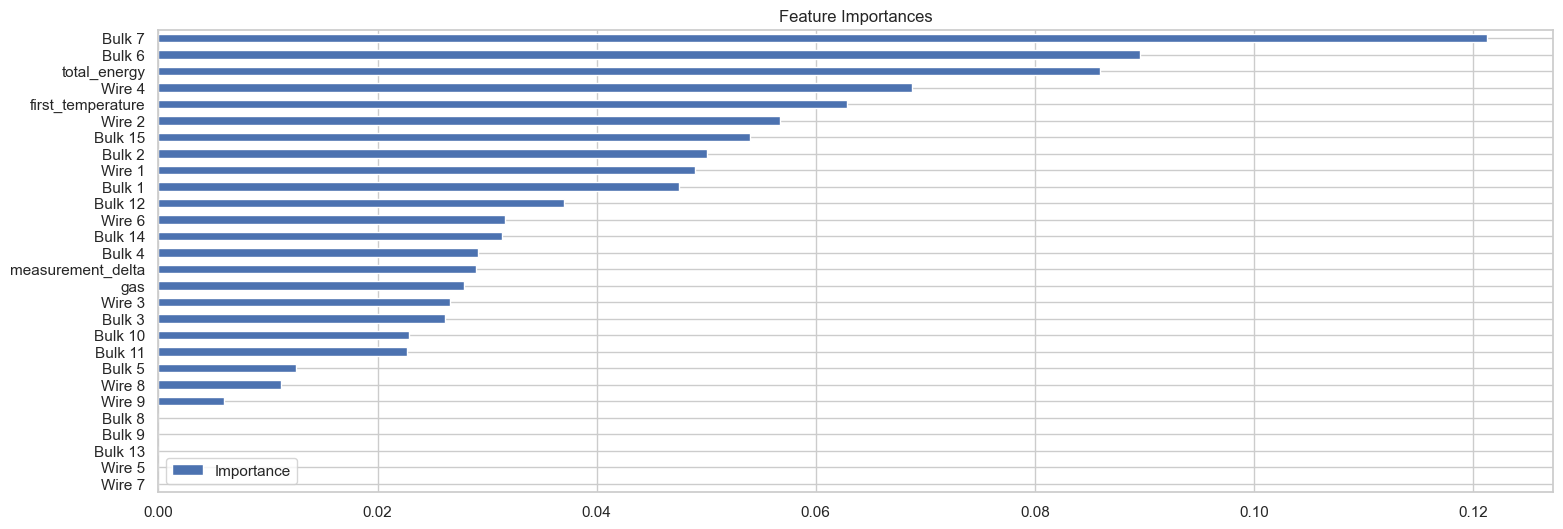

CPU times: total: 15min 21s
Wall time: 1min 3s


In [63]:
%%time 

xgb_pipe = Pipeline([('preprocess', preprocessing),  ('model', XGBRegressor(random_state=RND_ST))]) 

xgb_params = {
    'model__max_depth': optuna.distributions.IntDistribution(3, 15),
    'model__eta': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}

optuna_search_xgb = OptunaSearchCV(xgb_pipe, xgb_params, n_trials=30, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RND_ST) 
optuna_search_xgb.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_xgb.best_params_}')
print(f'RMSE на тренировочной выборке: {abs(optuna_search_xgb.best_score_)}')
display(optuna_search_xgb.best_estimator_)
ModelResults(optuna_search_xgb, 'XGBoost', results)

- Наиболее важные признаки: сыпучий материал Bulk 4, суммарной энергии нагрева total_energy, сыпучий материал Bulk 7.

### <a id='toc1_3_5_'></a>[LightGBM](#toc0_)

[I 2023-04-18 11:41:20,120] A new study created in memory with name: no-name-81c6c343-0ad1-440a-8ef2-0dac10810455
[I 2023-04-18 11:41:21,200] Trial 3 finished with value: -6.816036724374454 and parameters: {'model__max_depth': 2, 'model__learning_rate': 0.01472679025993017, 'model__n_estimators': 150}. Best is trial 3 with value: -6.816036724374454.
[I 2023-04-18 11:41:28,254] Trial 1 finished with value: -6.0712348600974675 and parameters: {'model__max_depth': 4, 'model__learning_rate': 0.035549678897854285, 'model__n_estimators': 600}. Best is trial 1 with value: -6.0712348600974675.
[I 2023-04-18 11:41:29,343] Trial 16 finished with value: -5.965211721066131 and parameters: {'model__max_depth': 3, 'model__learning_rate': 0.017551952466960636, 'model__n_estimators': 950}. Best is trial 16 with value: -5.965211721066131.
[I 2023-04-18 11:41:29,493] Trial 4 finished with value: -6.193805447297847 and parameters: {'model__max_depth': 4, 'model__learning_rate': 0.00499013031373812, 'mode



Лучшие параметры: {'model__max_depth': 2, 'model__learning_rate': 0.02520873552260211, 'model__n_estimators': 800}
MAE на тренировочной выборке: 5.954797566758552


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('model',
                 LGBMRegressor(learning_rate=0.02520873552260211, max_depth=2,
                               n_estimators=800, random_state=100423))])

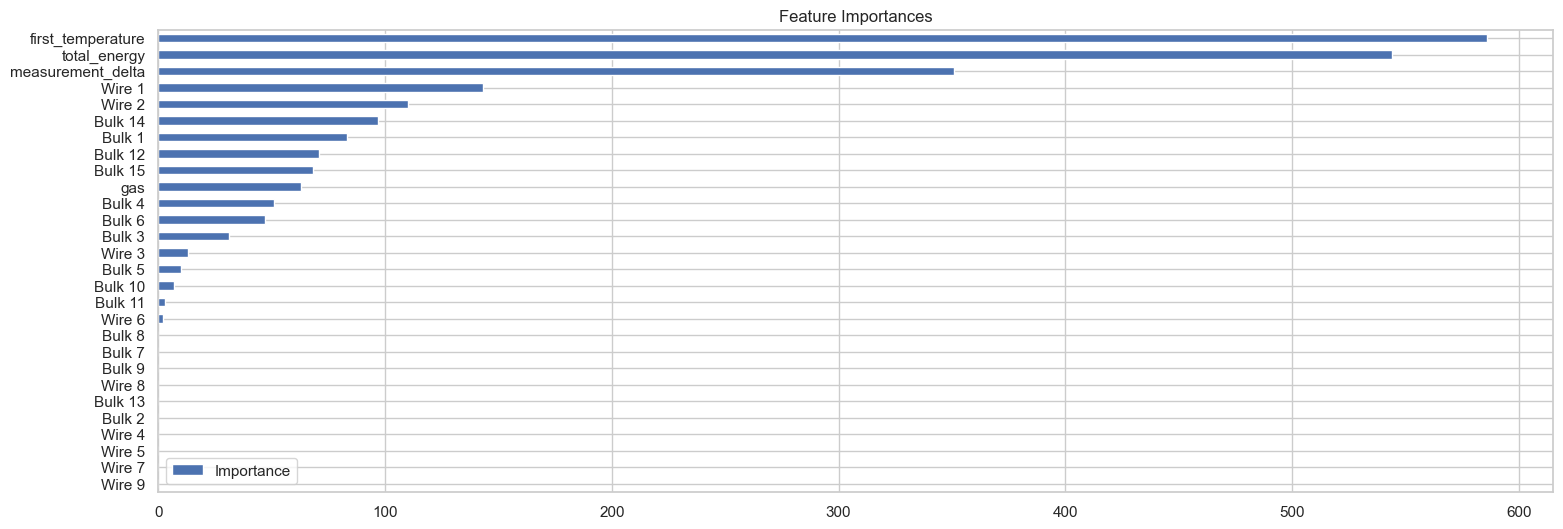

CPU times: total: 14min 38s
Wall time: 1min 3s


In [64]:
%%time

lgbm_pipe = Pipeline([('preprocess', preprocessing),  ('model', LGBMRegressor(random_state=RND_ST))]) 
lgbm_params = {
    'model__max_depth': optuna.distributions.IntDistribution(2, 15),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}


optuna_search_lgbm = OptunaSearchCV(lgbm_pipe, lgbm_params, n_trials=50, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RND_ST) 
optuna_search_lgbm.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_lgbm.best_params_}')
print(f'MAE на тренировочной выборке: {abs(optuna_search_lgbm.best_score_)}')
display(optuna_search_lgbm.best_estimator_)
ModelResults(optuna_search_lgbm, 'LightGBM', results)

- Наиболее важные признаки:  начальная температура first_temperature, суммарной энергии нагрева total_energy, время между первым и последними замерами.

### <a id='toc1_3_6_'></a>[CatBoost](#toc0_)

[I 2023-04-18 11:42:23,363] A new study created in memory with name: no-name-4f89e2b3-1b13-4351-a3ba-e769a4ed743f
[I 2023-04-18 11:42:29,392] Trial 13 finished with value: -6.541011546845418 and parameters: {'model__depth': 3, 'model__learning_rate': 0.012918875067842159, 'model__iterations': 263}. Best is trial 13 with value: -6.541011546845418.
[I 2023-04-18 11:42:29,538] Trial 1 finished with value: -5.943850162120815 and parameters: {'model__depth': 4, 'model__learning_rate': 0.047231797212813904, 'model__iterations': 227}. Best is trial 1 with value: -5.943850162120815.
[I 2023-04-18 11:42:37,533] Trial 5 finished with value: -5.829435660707012 and parameters: {'model__depth': 5, 'model__learning_rate': 0.04169109078923848, 'model__iterations': 401}. Best is trial 5 with value: -5.829435660707012.
[I 2023-04-18 11:42:39,948] Trial 0 finished with value: -6.095243787152837 and parameters: {'model__depth': 5, 'model__learning_rate': 0.019167424596265685, 'model__iterations': 315}. B



Лучшие параметры: {'model__depth': 4, 'model__learning_rate': 0.05662367526224717, 'model__iterations': 424}
MAE на тренировочной выборке: 5.805169520216903


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000002198DFCF3D0>)])

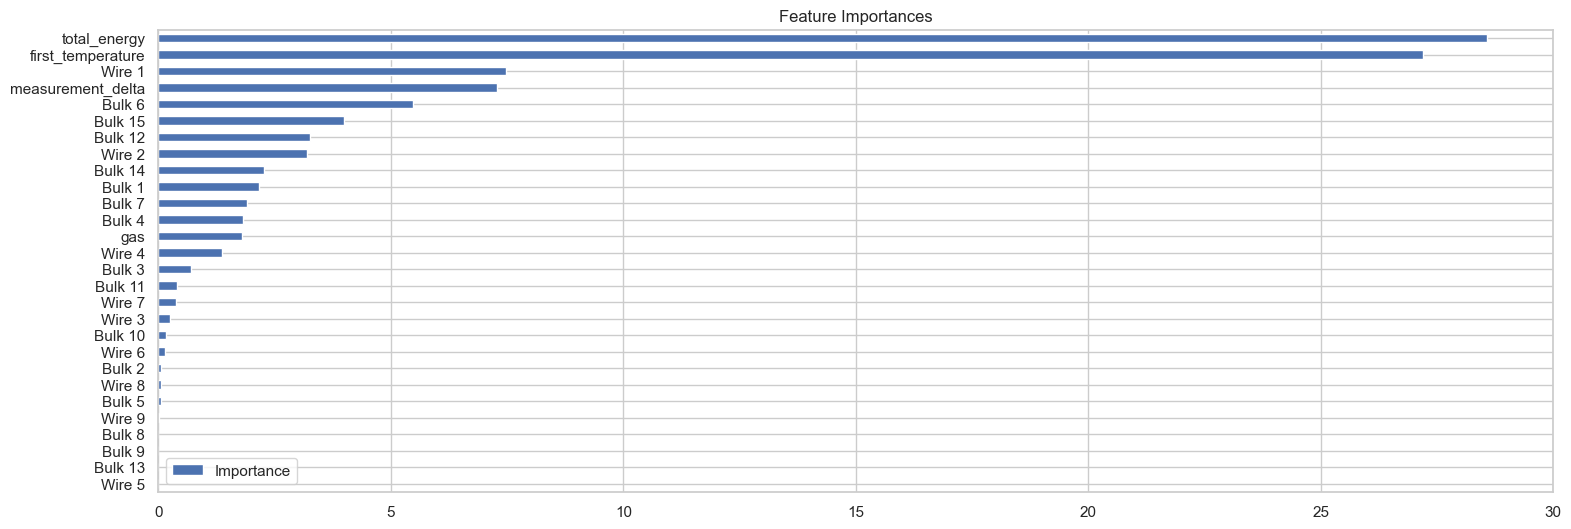

CPU times: total: 1h 11min 33s
Wall time: 5min 32s


In [65]:
%%time

cat_pipe = Pipeline([('preprocess', preprocessing),  ('model',CatBoostRegressor(random_state=RND_ST, verbose=False, early_stopping_rounds=300))]) 

cat_parameters = {'model__depth': optuna.distributions.IntDistribution(3, 10), 
              'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1, log=True), 
              'model__iterations': optuna.distributions.IntDistribution(100, 1000)}


optuna_search_cat = OptunaSearchCV(cat_pipe, cat_parameters, n_trials=30, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RND_ST) # cv=3,
optuna_search_cat.fit(features_train, target_train)


print('\n')
print(f'Лучшие параметры: {optuna_search_cat.best_params_}')
print(f'MAE на тренировочной выборке: {abs(optuna_search_cat.best_score_)}')
display(optuna_search_cat.best_estimator_)
ModelResults(optuna_search_cat, 'CatBoost', results)

- Наибольшую важность на модель оказали признаки суммарной энергии нагрева total_energy, начальная температура first_temperature, проволочный материал Wire 1.

### <a id='toc1_3_7_'></a>[Полученные результаты](#toc0_)

In [66]:
res_df = pd.DataFrame(results, index = ['MAE', 'Fit time,s', 'Prediction time,s'], columns = results.keys() )
res_df

,Lasso,Ridge,Random Forest,XGBoost,LightGBM,CatBoost
MAE,6.556825,6.141617,6.036806,5.831609,5.954798,5.805170
"Fit time,s",0.007482,0.005683,1.067785,0.677474,0.123648,0.401557
"Prediction time,s",0.002292,0.002137,0.022413,0.008232,0.005954,0.004429


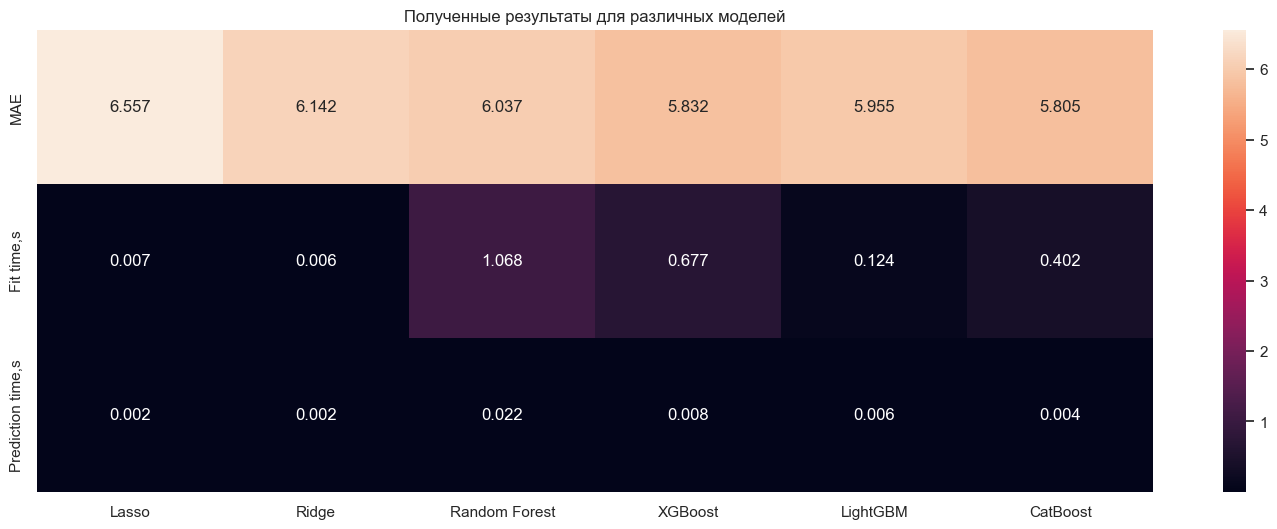

In [67]:
plt.figure(figsize=(18,6))
sns.heatmap(res_df, annot=True, fmt = '.3f')
plt.title('Полученные результаты для различных моделей')
plt.show()

По результатам сравнения наилушие показатели на кросс-валидации показала модель CatBoost.

## <a id='toc1_4_'></a>[Тестирование модели](#toc0_)

In [68]:
cat_predictions = optuna_search_cat.predict(features_test)
print(f'MAE на тестовой выборке для CatBoost: {mean_absolute_error(target_test, cat_predictions) }')

MAE на тестовой выборке для CatBoost: 6.038487409783212


Модель показала успешную метрику на тестовой выборке.

## <a id='toc1_5_'></a>[Адекватность модели](#toc0_)

Проверим модель на адекватность сравнив с dummy моделью.

In [69]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_pred = dummy_regr.predict(features_test)
print(f'MAE Dummy модели на тестовой выборке: {mean_absolute_error(target_test, dummy_pred)}')

MAE Dummy модели на тестовой выборке: 8.159506952700347


Выбранная модель показывает адекватные результаты по сравнению с более простой dummy моделью.

## <a id='toc1_6_'></a>[Общий вывод](#toc0_)

- Определены цель и задачи поставленного проекта.
- Проведен первичный анализ данных данных. Представлены данные о подаче сыпучих и проволочных матриалов, продвуке сплава газом, подаваемой электрической мощности на электроды ковша для различных партий при обработки стали. 
- Проведена предобработка данных. Удалены пропуски, обнаружены и обработаны аномальные значения. Данные объеденены по номеру партии стали.Подготовлены тренировочные и тестовые выборки.
- Рассмотрены модели Lasso, Ridge, RandomForest, XGBoost, LightGBM, CatBoost.
- Была выбрана модель CatBoost по наилучшим показателям метрики на кросс-валидации.
- Наиболее важные признаки: начальная температура first_temperature, суммарной энергии нагрева total_energy, время между первым и последними замерами, добавка проволочного матрериала Wire 1 и сыпучего материала Bulk 6.
- Модель показала метрику MAE = 6.069 < 6.8 на тестовых данных, что удовлетворяет условиям технического задания.
- Выбранная модель показывает адекватные результаты по сравнению с более простой dummy моделью.

# <a id='toc2_'></a>[Отчет](#toc0_)

В рамках проекта разработана модель предсказания температуры стали, с целью для оптимизации затрат на электроэнергию.

Выполнены все пункты плана: изучены предоставленные данные, проведена предобработка данных, исследовано несколько моделей, из которых была выбрана наилучшая по метрике MAE на кросс-валидации и затем проведена проверка метрики выбранной модели на тестовых данных, проверка на адекватность. Невыполненных пунктов плана нет.

Трудности в процессе реализации проекта возникли при изучении данных (что подразумевается в data_wire под проволочными материалами) - были решены путем уточняющих вопросов тимлиду, и при создании новых признаков - было решено путем изучения дополнительных материалов по электротехнике о связи активной, реактивной, полной мощностей и их физическом смысле.

Для реализации поставленной цели были проделаны следующие шаги:

- Поставлены цели и задачи, определена метрика и её пороговое значние (MAE < 6.8).

- При изучении были рассмотрены данные о подаче сыпучих и проволочных матриалов, продувке сплава газом, подаваемой электрической мощности на электроды ковша для различных партий при обработки стали. Построены гистограммы распределения различных признаков по предоставленным данным. Рассмотрены данные подаваемой на электроды активной и реактивной мощностей, времени начала и конца нагрева для каждой из партий стали. В данных о реактивной мощности присутсвовало одно отрицательное значение. Распределение в данных о подаваемом газе похоже логнормальное, пропуски в данных отсутствовали. Рассмотрены данные о сыпучих и проволочных материалах, а также времени подачи их в ковш. В данных присутствовали пропуски, предположительно из-за того, что данный материал в конкретную партию не подавался. В данных о температуре были предсталены замеры в различные временные отрезки обработки стали. В данных присутствовали выбросы и пропуски. 

- Проведена предобработка данных: удалены аномальные значения в данных о температуре и электродах, удалены пропуски в данных о температуре, пропуски в data_wire и data_bulk заполнены значением 0, как отсутсвие конкретной добавки в сталь при обработке. Целевым признаком является конечная температура расплава. Начальная температура использовалась как признак, промежуточные замеры не использовались. Добавлены новые признаки полной мощности total_power, суммарно затраченной энергии на переработку total_energy и временной разнице при замерах начальной и конечной температур measurement_delta. Из-за достаточно высокой корреляции между собой признаки активной, реактивной и полной мощностей было решено удалить, оставив только признак total_energy. Датасеты data_wire_time и data_bulk_time исключены из рассмотрения, так как временные шаги поступления материалов в ковш не влияет на начальные и коненчные показания температуры стали. Данные агрегированны по общему key - номер партии и объеденены в общую таблицу. Данные разделены на features и target. Подготовлены обучающая и тестовая выборки с соотношением 3:1.

- Рассмотрены модели Lasso, Ridge, модели XGBoost, LightGBM, CatBoost и модель RandomForest с различными гиперпараметрами. По итогу исследования были получены следующие метрики MAE на кросс-вадлидации: Lasso - 6.556825, Ridge - 6.141617, Random Forest - 6.036806, XGBoost - 5.831609, LightGBM - 5.954798, CatBoost - 5.805170. Наилучшей по метрике показала себя модель CatBoost со следующими гиперпараметрами:  глубины дерева 'depth' - 4, скорости обучения 'learning_rate' - 0.05662367526224717, количества итераций 'iterations' - 424. Наибольшую важность для выбранной модели оказали признаки суммарной энергии нагрева total_energy, начальная температура first_temperature, проволочный материал Wire 1, разность между первым и последним измерениями measurement_delta и сыпучий материал Bulk 6.

- Модель показала успешный результат на тестовых данных MAE - 6.038487409783212 и модель адекватна по сравнению с более простой dummy моделью предсказания среднего значения по таргету.